Importing nessesary libraries

CS 624 project

rainfall prediction using Big data pyspark

In [ ]:
# loading relevant libraries
!pip install pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col, when
from statistics import mode as _mode
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.util import MLUtils
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488490 sha256=75d1ccecdba13ba926a7da4a80400fb6f7bd5f0f352f1ef4ef4b777a919efa55
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
# Initialize Spark session
spark = SparkSession.builder.appName("Weather Data Processing").getOrCreate()



Loading the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Load the dataset
data = spark.read.csv("/content/drive/My Drive/Project/weatherAUS.csv", header=True, inferSchema=True)

# Show the first few rows of the dataset
data.show()

+----------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+-------+------------+
|      Date|Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RISK_MM|RainTomorrow|
+----------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+-------+------------+
|2008-12-01|  Albury|   13.4|   22.9|     0.6|         NA|      NA|          W|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1|       8|      NA|   16.9|   21.8|       No|  

In [ ]:
#Actual count of the data
data.count()

142193

Feature engeneering

In [ ]:
#Dropping unwanted columns
predict_rain = data.drop('Date', 'Location', 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm')
predict_rain.show(10)

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+-------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RISK_MM|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+-------+------------+
|   13.4|   22.9|     0.6|          W|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1|       No|    0.0|          No|
|    7.4|   25.1|       0|        WNW|           44|       NNW|       WSW|           4|          22|         44|         25|     1010.6|     1007.8|       No|    0.0|          No|
|   12.9|   25.7|       0|        WSW|           46|         W|       WSW|          19|          26|

In [ ]:
#Function for counting null values
def null_count():

    for columns in predict_rain.columns:
        print(columns + ': ' + str(predict_rain[predict_rain[columns] == 'NA'].count()))

In [ ]:
null_count()

MinTemp: 637
MaxTemp: 322
Rainfall: 1406
WindGustDir: 9330
WindGustSpeed: 9270
WindDir9am: 10013
WindDir3pm: 3778
WindSpeed9am: 1348
WindSpeed3pm: 2630
Humidity9am: 1774
Humidity3pm: 3610
Pressure9am: 14014
Pressure3pm: 13981
RainToday: 1406
RISK_MM: 0
RainTomorrow: 0


Data Cleaning

In [ ]:
from pyspark.sql.types import FloatType, DoubleType, LongType, IntegerType

# Print the datatype of each column
for column in predict_rain.columns:
    print(f'The datatype of {column} is {predict_rain.schema[column].dataType}')

# Calculate and print the mean of each column
for column in predict_rain.columns:
    if isinstance(predict_rain.schema[column].dataType, (FloatType, DoubleType, LongType, IntegerType)):
        mean_value = predict_rain.select(_mean(col(column))).collect()[0][0]
        print(f'The mean of {column} is {mean_value}')


The datatype of MinTemp is StringType()
The datatype of MaxTemp is StringType()
The datatype of Rainfall is StringType()
The datatype of WindGustDir is StringType()
The datatype of WindGustSpeed is StringType()
The datatype of WindDir9am is StringType()
The datatype of WindDir3pm is StringType()
The datatype of WindSpeed9am is StringType()
The datatype of WindSpeed3pm is StringType()
The datatype of Humidity9am is StringType()
The datatype of Humidity3pm is StringType()
The datatype of Pressure9am is StringType()
The datatype of Pressure3pm is StringType()
The datatype of RainToday is StringType()
The datatype of RISK_MM is DoubleType()
The datatype of RainTomorrow is StringType()
The mean of RISK_MM is 2.3606816087994695


In [ ]:
#Fill the numarical colums null values with mean values of that column
from pyspark.sql.functions import col, mean as _mean, when

# List of specific numeric columns to impute
specific_columns = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed',
                    'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                    'Humidity3pm', 'Pressure9am', 'Pressure3pm']

# Function to impute missing values with the mean
def impute_with_mean(df, column):
    mean_value = df.select(_mean(col(column))).collect()[0][0]
    df = df.withColumn(column, when(col(column).isNull() | (col(column) == "NA"), mean_value).otherwise(col(column)))
    return df

# Impute missing values for each column in the list
for column in specific_columns:
    predict_rain = impute_with_mean(predict_rain, column)

# Show the DataFrame after imputation
predict_rain.show()


+-------+-------+-----------------+-----------+-------------+----------+----------+---------------+------------+-----------+-----------+-----------+-----------+---------+-------+------------+
|MinTemp|MaxTemp|         Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|   WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RISK_MM|RainTomorrow|
+-------+-------+-----------------+-----------+-------------+----------+----------+---------------+------------+-----------+-----------+-----------+-----------+---------+-------+------------+
|   13.4|   22.9|              0.6|          W|           44|         W|       WNW|             20|          24|         71|         22|     1007.7|     1007.1|       No|    0.0|          No|
|    7.4|   25.1|                0|        WNW|           44|       NNW|       WSW|              4|          22|         44|         25|     1010.6|     1007.8|       No|    0.0|          No|
|   12.9|   25.7|                0|     

In [ ]:
#Function for counting null values
def null_count():

    for columns in predict_rain.columns:
        print(columns + ': ' + str(predict_rain[predict_rain[columns] == 'NA'].count()))

In [ ]:
#Rechecking the null values for numerical columns
null_count()

MinTemp: 0
MaxTemp: 0
Rainfall: 0
WindGustDir: 9330
WindGustSpeed: 0
WindDir9am: 10013
WindDir3pm: 3778
WindSpeed9am: 0
WindSpeed3pm: 0
Humidity9am: 0
Humidity3pm: 0
Pressure9am: 0
Pressure3pm: 0
RainToday: 1406
RISK_MM: 0
RainTomorrow: 0


In [ ]:

# List of categorical columns to handle
categorical_columns = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

# Function to get the mode of a column
def get_mode(df, column):
    return df.groupBy(column).count().orderBy('count', ascending=False).collect()[0][0]

# Dictionary to store modes for each categorical column
modes = {column: get_mode(predict_rain, column) for column in categorical_columns}

# Replace missing values with the mode for each categorical column
for column in categorical_columns:
    mode_value = modes[column]
    predict_rain = predict_rain.withColumn(column, when(col(column).isNull() | (col(column) == 'NA'), mode_value).otherwise(col(column)))

# Show the DataFrame after replacing missing values
predict_rain.show()


+-------+-------+-----------------+-----------+-------------+----------+----------+---------------+------------+-----------+-----------+-----------+-----------+---------+-------+------------+
|MinTemp|MaxTemp|         Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|   WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RISK_MM|RainTomorrow|
+-------+-------+-----------------+-----------+-------------+----------+----------+---------------+------------+-----------+-----------+-----------+-----------+---------+-------+------------+
|   13.4|   22.9|              0.6|          W|           44|         W|       WNW|             20|          24|         71|         22|     1007.7|     1007.1|       No|    0.0|          No|
|    7.4|   25.1|                0|        WNW|           44|       NNW|       WSW|              4|          22|         44|         25|     1010.6|     1007.8|       No|    0.0|          No|
|   12.9|   25.7|                0|     

In [ ]:
#Re checking the null values for categorical values
null_count()

MinTemp: 0
MaxTemp: 0
Rainfall: 0
WindGustDir: 0
WindGustSpeed: 0
WindDir9am: 0
WindDir3pm: 0
WindSpeed9am: 0
WindSpeed3pm: 0
Humidity9am: 0
Humidity3pm: 0
Pressure9am: 0
Pressure3pm: 0
RainToday: 0
RISK_MM: 0
RainTomorrow: 0


In [ ]:
# List of numerical columns to cast to DoubleType
numerical_list = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                  'Humidity3pm', 'Pressure9am', 'Pressure3pm']

# Cast numerical columns to DoubleType
for column in numerical_list:
    predict_rain = predict_rain.withColumn(column, col(column).cast(DoubleType()))

# Verify the changes
predict_rain.printSchema()

root
 |-- MinTemp: double (nullable = true)
 |-- MaxTemp: double (nullable = true)
 |-- Rainfall: double (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: double (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: double (nullable = true)
 |-- WindSpeed3pm: double (nullable = true)
 |-- Humidity9am: double (nullable = true)
 |-- Humidity3pm: double (nullable = true)
 |-- Pressure9am: double (nullable = true)
 |-- Pressure3pm: double (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RISK_MM: double (nullable = true)
 |-- RainTomorrow: string (nullable = true)



Data Preprocessing

In [ ]:
# List of categorical columns to index
categorical_list = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']

# Create indexers for categorical columns
indexers = [StringIndexer(inputCol=column, outputCol=column + "_index") for column in categorical_list]

# Define the pipeline with the indexers
pipeline = Pipeline(stages=indexers)

# Fit the pipeline and transform the data
pred_indexers = pipeline.fit(predict_rain).transform(predict_rain)

# Show the first 10 rows of the transformed DataFrame
pred_indexers.show(10)

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+-------+------------+-----------------+----------------+----------------+---------------+------------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RISK_MM|RainTomorrow|WindGustDir_index|WindDir9am_index|WindDir3pm_index|RainToday_index|RainTomorrow_index|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+-------+------------+-----------------+----------------+----------------+---------------+------------------+
|   13.4|   22.9|     0.6|          W|         44.0|         W|       WNW|        20.0|        24.0|       71.0|       22.0|     1007.7|     1007.1|       No|    0.0|          No|              0.0|  

In [ ]:
target = ['RainTomorrow_index']

# Include only numerical and indexed categorical columns
assembler = VectorAssembler(
    inputCols = [columns for columns in pred_indexers.columns
                 if columns not in target and columns.endswith('_index') or columns in numerical_list],
    outputCol = 'feature_vector')

pred_indexers_data = assembler.transform(pred_indexers)

In [ ]:
   pred_indexers_data.show(10)


+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+-------+------------+-----------------+----------------+----------------+---------------+------------------+--------------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RISK_MM|RainTomorrow|WindGustDir_index|WindDir9am_index|WindDir3pm_index|RainToday_index|RainTomorrow_index|      feature_vector|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+-------+------------+-----------------+----------------+----------------+---------------+------------------+--------------------+
|   13.4|   22.9|     0.6|          W|         44.0|         W|       WNW|        20.0|        24.0|       71.0|       22.0|     1007.7|

Data Visualization.

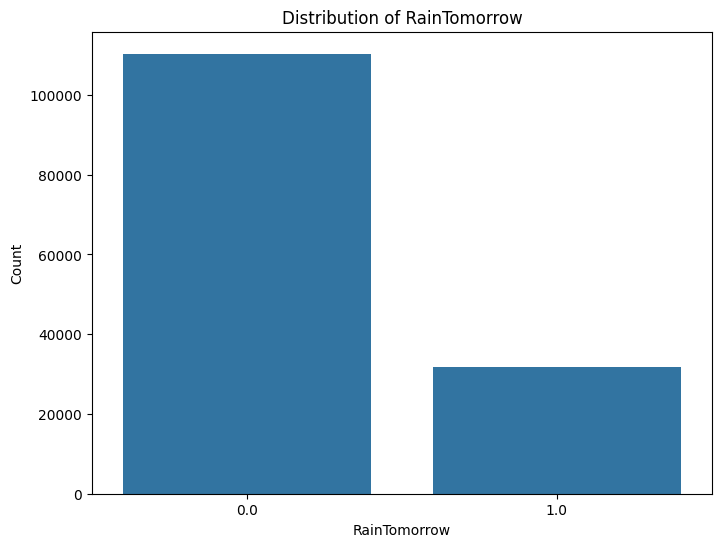

In [ ]:
import matplotlib.pyplot as plt
import plotly.express as px
# Convert Spark DataFrame to Pandas DataFrame for visualization
pred_indexers_pd = pred_indexers.select(
    [col for col in pred_indexers.columns if col.endswith('_index') or col in ['MinTemp', 'MaxTemp', 'Rainfall', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'RainTomorrow_index']]
).toPandas()

# Visualization: Distribution of the target variable (RainTomorrow)
plt.figure(figsize=(8, 6))
sns.countplot(x='RainTomorrow_index', data=pred_indexers_pd)
plt.title('Distribution of RainTomorrow')
plt.xlabel('RainTomorrow')
plt.ylabel('Count')
plt.show()

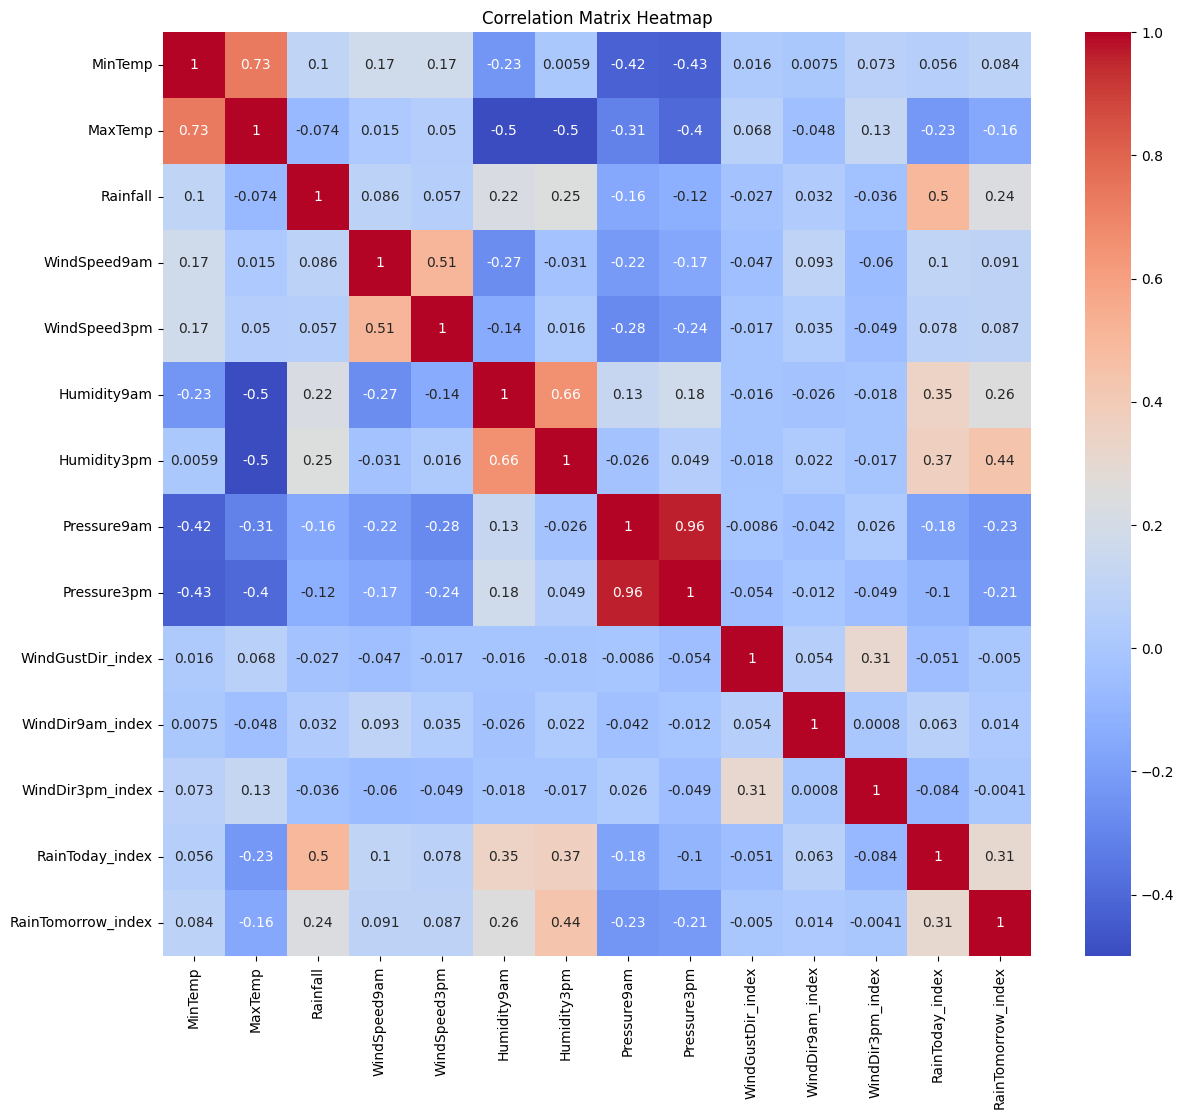

In [ ]:
# Visualization: Correlation matrix heatmap
plt.figure(figsize=(14, 12))
correlation_matrix = pred_indexers_pd.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

Divide the data into training and testing.

In [ ]:
rain_test, rain_train = pred_indexers_data.randomSplit([0.2, 0.8], seed = 123)
print("test data count",rain_test.count())


test data count 28688


In [ ]:
print("train data count",rain_train.count())


train data count 113505


Logistic regression

In [ ]:
LogReg_Classifier = LogisticRegression(regParam = 0.3, labelCol = "RainTomorrow_index", featuresCol = 'feature_vector', \
                                       maxIter = 20,  elasticNetParam = 0.8)

In [ ]:
LogReg_Model = LogReg_Classifier.fit(rain_train)


In [ ]:
LogReg_Prediction = LogReg_Model.transform(rain_test)

LogReg_Prediction.head(5)

[Row(MinTemp=-8.5, MaxTemp=0.6, Rainfall=1.0, WindGustDir='S', WindGustSpeed=31.0, WindDir9am='WNW', WindDir3pm='SW', WindSpeed9am=20.0, WindSpeed3pm=15.0, Humidity9am=47.0, Humidity3pm=72.0, Pressure9am=1017.6537584159663, Pressure3pm=1015.258203537901, RainToday='No', RISK_MM=0.0, RainTomorrow='No', WindGustDir_index=5.0, WindDir9am_index=14.0, WindDir3pm_index=4.0, RainToday_index=0.0, RainTomorrow_index=0.0, feature_vector=DenseVector([-8.5, 0.6, 1.0, 31.0, 20.0, 15.0, 47.0, 72.0, 1017.6538, 1015.2582, 5.0, 14.0, 4.0, 0.0]), rawPrediction=DenseVector([1.2427, -1.2427]), probability=DenseVector([0.776, 0.224]), prediction=0.0),
 Row(MinTemp=-8.0, MaxTemp=15.1, Rainfall=0.2, WindGustDir='W', WindGustSpeed=39.98429165757619, WindDir9am='NNW', WindDir3pm='NW', WindSpeed9am=6.0, WindSpeed3pm=13.0, Humidity9am=96.0, Humidity3pm=33.0, Pressure9am=1029.6, Pressure3pm=1025.3, RainToday='No', RISK_MM=0.0, RainTomorrow='No', WindGustDir_index=0.0, WindDir9am_index=9.0, WindDir3pm_index=8.0, R

In [ ]:
LogReg_Evaluator = MulticlassClassificationEvaluator(labelCol = "RainTomorrow_index", predictionCol = "prediction", \
                                                     metricName = "accuracy")

In [ ]:
LogReg_Accuracy = LogReg_Evaluator.evaluate(LogReg_Prediction)


In [ ]:
print('Logistic Regression Accuracy is : ' + str(LogReg_Accuracy * 100))
print('Test Error is : ' + str(1 - LogReg_Accuracy))

Logistic Regression Accuracy is : 77.49581706636921
Test Error is : 0.2250418293363079


ROC AUC: 0.50


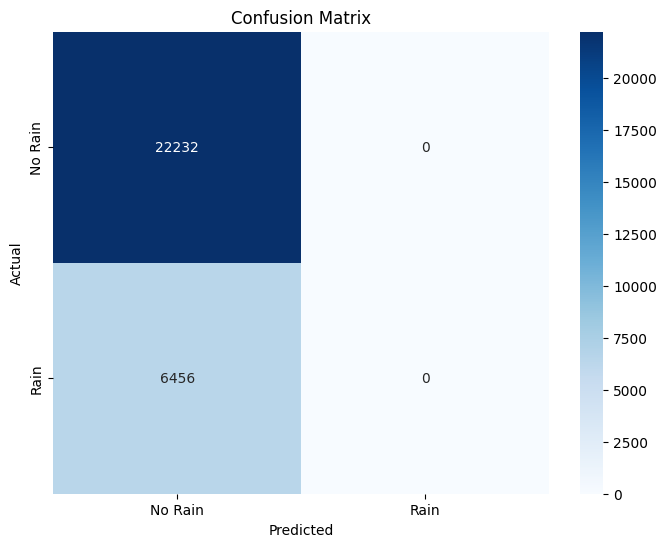

In [ ]:
# Import necessary libraries for visualization
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Evaluate the model using a BinaryClassificationEvaluator
binary_evaluator = BinaryClassificationEvaluator(labelCol='RainTomorrow_index')
roc_auc = binary_evaluator.evaluate(LogReg_Prediction, {binary_evaluator.metricName: 'areaUnderROC'})
print(f'ROC AUC: {roc_auc:.2f}')

# Convert Spark DataFrame to Pandas DataFrame for visualization
LogReg_Prediction_pd = LogReg_Prediction.select('RainTomorrow_index', 'prediction', 'probability').toPandas()

# Confusion Matrix
conf_matrix = confusion_matrix(LogReg_Prediction_pd['RainTomorrow_index'], LogReg_Prediction_pd['prediction'])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



Random forest

In [ ]:
RF_Classifier = RandomForestClassifier(labelCol = 'RainTomorrow_index', featuresCol = 'feature_vector',  maxDepth = 5,
    maxBins = 32, numTrees = 500)

RF_Model = RF_Classifier.fit(rain_train)

In [ ]:
RF_Prediction = RF_Model.transform(rain_test)


In [ ]:
RF_Prediction.head(5)


[Row(MinTemp=-8.5, MaxTemp=0.6, Rainfall=1.0, WindGustDir='S', WindGustSpeed=31.0, WindDir9am='WNW', WindDir3pm='SW', WindSpeed9am=20.0, WindSpeed3pm=15.0, Humidity9am=47.0, Humidity3pm=72.0, Pressure9am=1017.6537584159663, Pressure3pm=1015.258203537901, RainToday='No', RISK_MM=0.0, RainTomorrow='No', WindGustDir_index=5.0, WindDir9am_index=14.0, WindDir3pm_index=4.0, RainToday_index=0.0, RainTomorrow_index=0.0, feature_vector=DenseVector([-8.5, 0.6, 1.0, 31.0, 20.0, 15.0, 47.0, 72.0, 1017.6538, 1015.2582, 5.0, 14.0, 4.0, 0.0]), rawPrediction=DenseVector([382.6643, 117.3357]), probability=DenseVector([0.7653, 0.2347]), prediction=0.0),
 Row(MinTemp=-8.0, MaxTemp=15.1, Rainfall=0.2, WindGustDir='W', WindGustSpeed=39.98429165757619, WindDir9am='NNW', WindDir3pm='NW', WindSpeed9am=6.0, WindSpeed3pm=13.0, Humidity9am=96.0, Humidity3pm=33.0, Pressure9am=1029.6, Pressure3pm=1025.3, RainToday='No', RISK_MM=0.0, RainTomorrow='No', WindGustDir_index=0.0, WindDir9am_index=9.0, WindDir3pm_index=8

In [ ]:
RF_Evaluator = MulticlassClassificationEvaluator(labelCol = 'RainTomorrow_index', predictionCol = 'prediction')


In [ ]:
RF_Accuracy = RF_Evaluator.evaluate(RF_Prediction)


In [ ]:
print('Random Forest Accuracy is : ' + str(RF_Accuracy * 100))
print('Test Error is : ' + str(1 - RF_Accuracy))

Random Forest Accuracy is : 81.233527499328
Test Error is : 0.18766472500671993


ROC AUC: 0.83


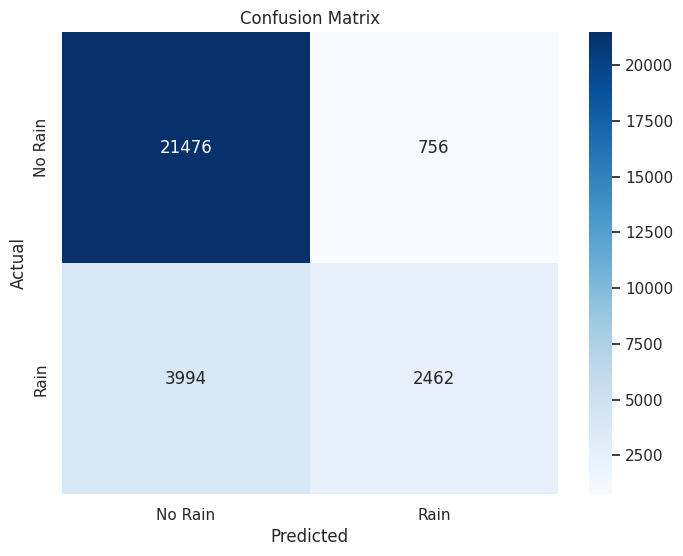

In [ ]:
# Import necessary libraries for visualization
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Evaluate the model using a BinaryClassificationEvaluator
binary_evaluator = BinaryClassificationEvaluator(labelCol='RainTomorrow_index')
roc_auc = binary_evaluator.evaluate(RF_Prediction, {binary_evaluator.metricName: 'areaUnderROC'})
print(f'ROC AUC: {roc_auc:.2f}')

# Convert Spark DataFrame to Pandas DataFrame for visualization
RF_Prediction_pd = RF_Prediction.select('RainTomorrow_index', 'prediction', 'probability').toPandas()

# Confusion Matrix
conf_matrix = confusion_matrix(RF_Prediction_pd['RainTomorrow_index'], RF_Prediction_pd['prediction'])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


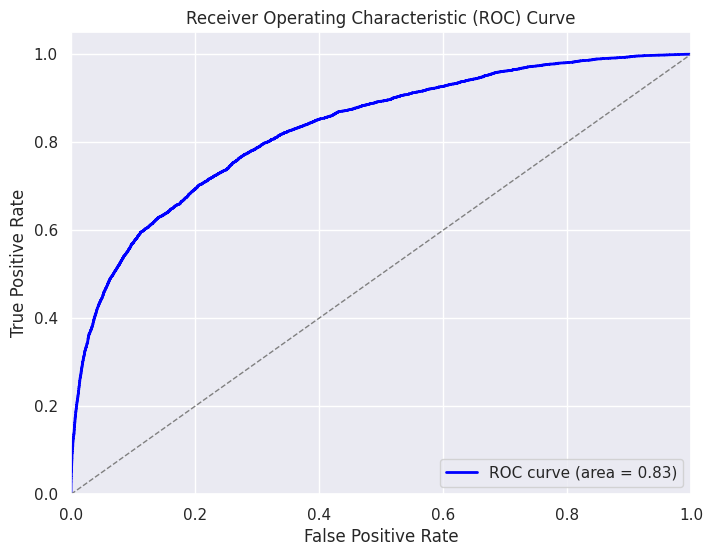

In [ ]:
# ROC Curve
plt.figure(figsize=(8, 6))
y_true = RF_Prediction_pd['RainTomorrow_index']
y_proba = RF_Prediction_pd['probability'].apply(lambda x: x[1])  # Extract probability of the positive class

fpr, tpr, thresholds = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Comparision between two models.

<Axes: >

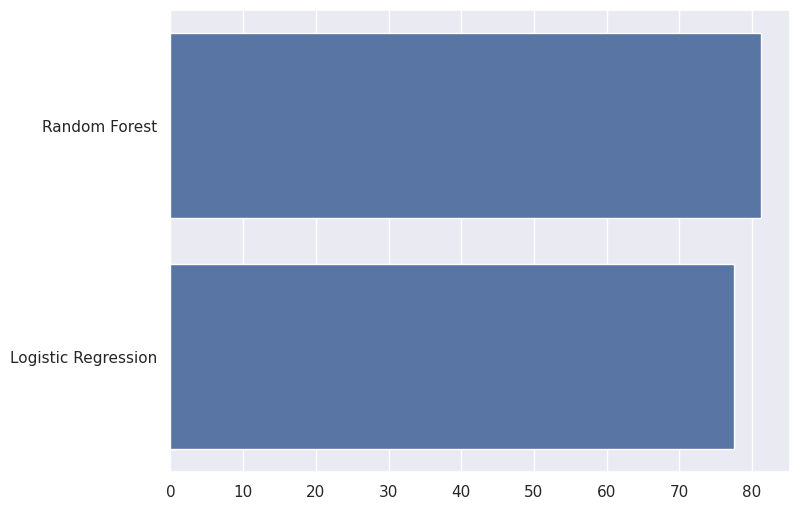

In [ ]:
sns.set(rc = {'figure.figsize':(8, 6)})

model_classifiers = ['Random Forest', 'Logistic Regression']

model_accuracies = [RF_Accuracy * 100, LogReg_Accuracy * 100]

sns.barplot(y = model_classifiers, x = model_accuracies)